In [1]:
#DATA 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.optimize import root_scalar
Data= pd.read_csv(r'dkumkr3flw83shfb.csv',usecols=lambda column: column != 'gvkey')
DLTTQ = Data[["datadate", "dlttq"]]
DLCQ= Data [["datadate","dlcq"]]
CRISP= pd.read_csv(r'ypqhws12p8apczk0.csv',usecols=lambda column: column != 'PERMNO')
CRISP.set_index("date", inplace=True)
RF= pd.read_csv(r'DGS1.csv')
RF.set_index("observation_date", inplace=True)
RF.index = pd.to_datetime(RF.index)
#capitalization boursiere
S_obs = CRISP["PRC"] * CRISP["SHROUT"]
S_obs.index = pd.to_datetime(S_obs.index)



#Lt   par interpolation 
#DLCQ.loc[:, "dlcq"] *= 1000
#DLTTQ.loc[:, "dlttq"] *= 1000
L_quarterly = DLCQ[["dlcq"]].values + 0.5 * DLTTQ[["dlttq"]].values
L_quarterly = pd.DataFrame(L_quarterly, columns=["Lt"], index=DLCQ["datadate"])
L_quarterly.index = pd.to_datetime(L_quarterly.index)
dates_daily = pd.bdate_range(start= L_quarterly.index[0], end=L_quarterly.index[-1], freq="D")
dates_daily = dates_daily[(dates_daily == L_quarterly.index[0]) | (dates_daily.weekday < 5)]

L_daily = L_quarterly.reindex(dates_daily)
L_daily["Lt"] = L_daily["Lt"].interpolate(method="linear")

##########################
start_date = L_daily.index.min()
S_obs = S_obs[S_obs.index >= start_date]/1000
L_matched = L_daily.reindex(S_obs.index)
L_series=L_matched["Lt"]
RF_matched = RF.reindex(S_obs.index).fillna(method="ffill")
RF_matched = RF_matched["DGS1"]/100


Log_returns = np.log(S_obs / S_obs.shift(1)).dropna()
sigma = Log_returns.std() * np.sqrt(252)


print("L_matched:",L_daily)
#print(L_quarterly)


L_matched:                      Lt
2023-12-31  2633.000000
2024-01-01  2631.653061
2024-01-02  2630.306122
2024-01-03  2628.959184
2024-01-04  2627.612245
...                 ...
2024-12-25  2651.757576
2024-12-26  2656.318182
2024-12-27  2660.878788
2024-12-30  2665.439394
2024-12-31  2670.000000

[263 rows x 1 columns]


C:\Users\harol\AppData\Local\Temp\ipykernel_12516\1949417989.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  RF_matched = RF.reindex(S_obs.index).fillna(method="ffill")


In [25]:
 
def equity_value(v, sigma,L, r, S_obs):
    D = L
    d1 = (np.log(v / D) + (r + 0.5 * sigma**2)) / sigma
    d2 = d1 - sigma
    return v * norm.cdf(d1) - D * np.exp(-r) * norm.cdf(d2) - S_obs


def invert_asset_value(S_obs, sigma, L, r):
    result = root_scalar(
        lambda v: equity_value(v, sigma,L, r, S_obs),
        bracket=[1e-6, 1e5], # MAX S-L,1  ET S+L
        method='brentq'
    )
    return result.root if result.converged else np.nan


def estimate_assets_iteratively(S_obs_series, L_series, r, sigma_equity_init, epsilon=1e-4, max_iter=100):
    m = len(S_obs_series)
    sigma_prev = sigma_equity_init

    for iteration in range(max_iter):
        print(f"Iteration {iteration + 1}/{max_iter}")
        v_series = []
        for j in range(m):
            v_j = invert_asset_value(S_obs_series[j], sigma_prev, L_series[j], r[j])
            v_series.append(v_j)
        v_series = np.array(v_series)

        log_returns = np.diff(np.log(v_series))
        sigma_new = np.std(log_returns)*np.sqrt(252)

        if np.abs(sigma_new - sigma_prev) < epsilon:
            break
        sigma_prev = sigma_new

    return v_series, sigma_new

v_series, sigma_final = estimate_assets_iteratively(S_obs.values, L_matched["Lt"].values, RF_matched.values, sigma_equity_init=sigma)

print("Final sigma:", sigma_final.round(5))
df_results = pd.DataFrame({
    "Date": L_matched.index[:len(v_series)],
    "S_obs": S_obs.iloc[:len(v_series)],
    "v_est": v_series
})
print(df_results)

Iteration 1/100
Final sigma: 0.312
                 Date        S_obs         v_est
date                                            
2024-01-02 2024-01-02  31397.28000  33904.313636
2024-01-03 2024-01-03  30431.48000  32936.979260
2024-01-04 2024-01-04  30466.60000  32969.814090
2024-01-05 2024-01-05  30712.44000  33214.621124
2024-01-08 2024-01-08  31063.64000  33565.038055
...               ...          ...           ...
2024-12-24 2024-12-24  27461.84979  29999.151844
2024-12-26 2024-12-26  27514.29126  30060.590488
2024-12-27 2024-12-27  27409.40832  29960.844579
2024-12-30 2024-12-30  27024.83754  29581.413685
2024-12-31 2024-12-31  27094.75950  29655.966092

[252 rows x 3 columns]


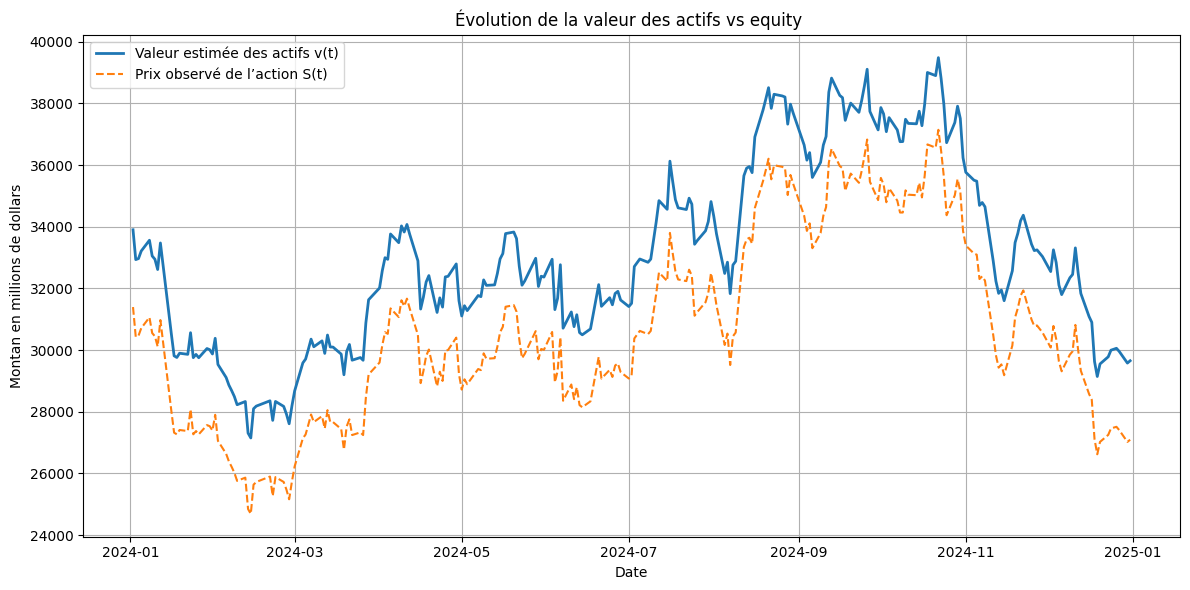

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_results["Date"], df_results["v_est"], label="Valeur estimée des actifs v(t)", linewidth=2)
plt.plot(df_results["Date"], df_results["S_obs"], label="Prix observé de l’action S(t)", linestyle="--")
plt.title("Évolution de la valeur des actifs vs equity ")
plt.xlabel("Date")
plt.ylabel("Montan en millions de dollars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#question 4 

D_1 = L_matched.iloc[-1]["Lt"]
D_20 = DLTTQ.iloc[-1]["dlttq"] 


start_date = L_matched.index[-1]
end_date = start_date + pd.DateOffset(years=20)

dates = pd.date_range(start=start_date , end=end_date, freq="YE")


interpolated_series = pd.Series(index=np.arange(1, 21, 1), dtype=float)

interpolated_series.iloc[0] = D_1       # valeur à 1 an
interpolated_series.iloc[-1] = D_20     # valeur à 20 ans

# 3. Interpolation linéaire
interpolated_series = interpolated_series.interpolate(method="linear")

# 4. Résultat propre dans un  tableau  pour l'affichage
interpolated_df = interpolated_series.to_frame(name="Lt")
#deux chiffre apèrs la virgule 
interpolated_df = interpolated_df.round(2)


print(interpolated_df)
# print taille interpolate 
print("Taille de la série interpolée :", interpolated_df.shape)

         Lt
1   2670.00
2   2801.68
3   2933.37
4   3065.05
5   3196.74
6   3328.42
7   3460.11
8   3591.79
9   3723.47
10  3855.16
11  3986.84
12  4118.53
13  4250.21
14  4381.89
15  4513.58
16  4645.26
17  4776.95
18  4908.63
19  5040.32
20  5172.00
Taille de la série interpolée : (20, 1)


In [13]:
import numpy as np

#nelson siegel courbe 
def nelson_siegel_smoothing(T,beta0,beta1,beta2,beta3,tau,theta):

    factor1= (1-np.exp(-T/tau))/(T/tau)
    factor2= factor1 - np.exp(-T/tau)
    factor3=(1-np.exp(-T/theta))/(T/theta)-np.exp(-T/theta)
    
    
    return beta0 + beta1*factor1 + beta2*factor2 + beta3*factor3
#parametre de la courbe de taux en date du 02/01/2025
beta0=1.3997809781669e-05
beta1=4.17537838746407
beta2=-124.32776755909
beta3=134.379235533314
tau=12.3652373905849
theta=12.9049079240786
#dates de maturité en anné entre 1 et 20 ans
T = np.arange(1, 21, 1)
#calcul des taux d'interet
interest_rates = nelson_siegel_smoothing(T, beta0, beta1, beta2, beta3, tau, theta)
print("Taux d'intérêt interpolés :")
print(T)
print(interest_rates.round(2))

Taux d'intérêt interpolés :
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[4.19 4.22 4.25 4.3  4.34 4.39 4.44 4.49 4.54 4.58 4.63 4.67 4.71 4.75
 4.78 4.81 4.84 4.86 4.88 4.89]


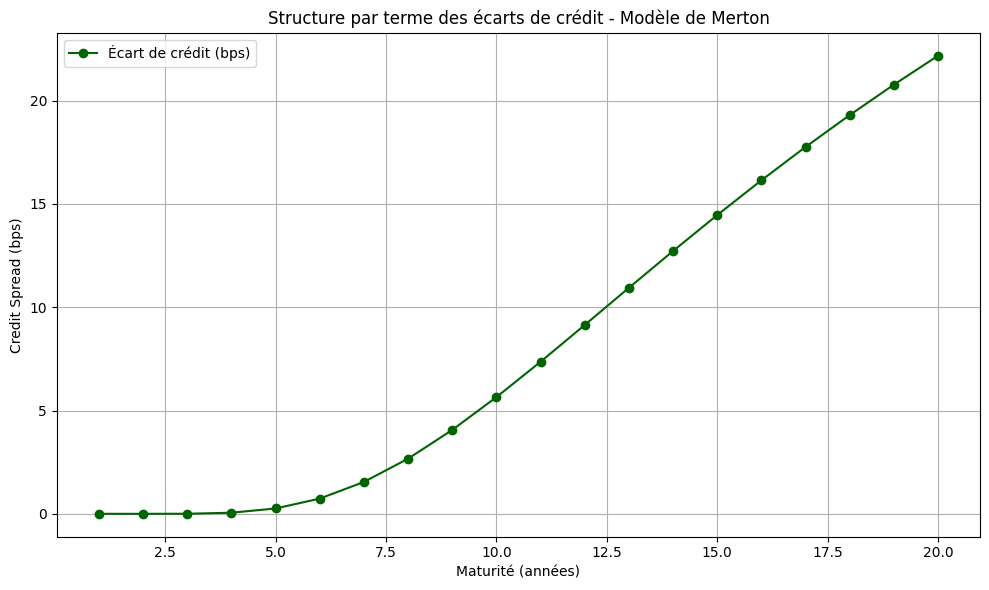

    Maturité (années)  Écart de crédit (bps)
0                   1                 0.0000
1                   2                 0.0000
2                   3                 0.0038
3                   4                 0.0531
4                   5                 0.2583
5                   6                 0.7359
6                   7                 1.5427
7                   8                 2.6682
8                   9                 4.0594
9                  10                 5.6466
10                 11                 7.3603
11                 12                 9.1407
12                 13                10.9398
13                 14                12.7221
14                 15                14.4627
15                 16                16.1453
16                 17                17.7608
17                 18                19.3045
18                 19                20.7762
19                 20                22.1774


In [23]:
#question 5 :Modele de Merton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm


# Paramètres de Merton
v0 = v_series[-1]  # Ensure v_series is defined in a previous cell
M_df = interpolated_df["Lt"]
sigma = sigma_final  # volatilité des actifs
  


def merton_debt_value(v, M, r, sigma, T):
    d1 = (np.log(v / M) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return M * np.exp(-r * T) * norm.cdf(d2) + v * norm.cdf(-d1)

# Calcul des spreads
T_vals = np.arange(1, 21, 1)  # Maturités de 1 à 20 ans
credit_spreads = []
r_=[]  
for T in T_vals: # Convert to years directly using integer difference
    
    r=interest_rates[T-1] / 100  # Convert to decimal
    M = M_df.iloc[T-1]  # Maturité correspondante
    D = merton_debt_value(v0, M, r, sigma, T)
    s_T = -(1 / T) * np.log(D / M) - r
    credit_spreads.append(s_T * 10000)  # en bps
  # Append only valid T_vals
    r_.append(r)  # Append the corresponding r values
# Plot
plt.figure(figsize=(10, 6))
plt.plot(T_vals , credit_spreads, marker='o', color='darkgreen', label="Écart de crédit (bps)")
plt.title("Structure par terme des écarts de crédit - Modèle de Merton")
plt.xlabel("Maturité (années)")
plt.ylabel("Credit Spread (bps)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

credit_spreads_df = pd.DataFrame({
    "Maturité (années)": T_vals ,
    "Écart de crédit (bps)": credit_spreads })

print(credit_spreads_df.round(4))


In [27]:
'''plot l_matched
plt.figure(figsize=(12, 6))
plt.plot(L_daily.index, L_daily.values, label="Valeur de la dette Lt", linewidth=2, color='blue')
plt.title("Évolution de la valeur de la dette Lt")
plt.xlabel("Date")
plt.ylabel("Montant en millions de dollars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()'''

'plot l_matched\nplt.figure(figsize=(12, 6))\nplt.plot(L_daily.index, L_daily.values, label="Valeur de la dette Lt", linewidth=2, color=\'blue\')\nplt.title("Évolution de la valeur de la dette Lt")\nplt.xlabel("Date")\nplt.ylabel("Montant en millions de dollars")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()'